# Looking at the demonstration clusters

We selected two galaxy clusters to act as a demonstration of the various stages of measuring hydrostatic masses using XGA; SDSSXCS-55 and SDSSXCS-6955. They were selected to be quite different in signal to noise (SDSSXCS-55 has significantly higher SN than SDSSXCS-6955), as well as being at different ends of the cluster mass scale (SDSSXCS-55 is a much more massive system).

This notebook is used to generate the demonstration-cluster-related figures which are in the methodology section of the paper. It was intended to be run after the analyses have already taken place, so that the existing products and results are being read back into the ClusterSample rather than being measured from scratch. We also make use of some of the more advanced features of the various product 'view' methods, to customise the figures for the paper.

## Import statements

In [1]:
import pandas as pd
# This makes sure that, in this notebook, we can display all columns in a Pandas dataframe
pd.set_option('display.max_columns', None)
from astropy.units import Quantity, def_unit, Unit

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

from common import xcs3p_colour, xcs_cosmo
import xga
xga.NUM_CORES = 10
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.imagetools.misc import physical_rad_to_pix
from xga.utils import r500 as r500_unit
from xga.imagetools.psf import rl_psf
from xga.sourcetools.deproj import shell_ann_vol_intersect
from xga.products.profile import GasTemperature3D, HydrostaticMass
from xga.sourcetools.density import inv_abel_fitted_model
from xga.sas.phot import emosaic

## Reading data for the demonstration cluster sub-sample

Below we define the names of the clusters we have selected as the demonstration pair. They were chosen in a fairly heuristic way, by looking at images of the clusters (as well as XGA measured results) to find a pair that we hoped would provide a useful contrast to each other. We also tried to make sure that they had multiple observations, and that at least one had required manual adjustment of the region files:

In [2]:
chosen_names = ['SDSSXCS-55', 'SDSSXCS-6955']

We use the chosen names to find the relevant entries in the SDSSRM-XCS ([Giles et al. 2022](https://arxiv.org/abs/2202.11107)) catalogue used in this work:

In [3]:
# Read the csv in using Pandas
xcs3p = pd.read_csv("../sample_files/xcs3p_sdssrm_clusters.csv")
# Select only those rows which correspond to our example clusters
example_clusters = xcs3p[xcs3p['name'].isin(chosen_names)]
# Re-order the rows so they're in the same order as the chosen names are defined in the cell above
example_clusters = example_clusters.reset_index(drop=True).reindex([1, 0])

# Take a quick look
example_clusters

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,z,r500,r500-,r500+,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lx_500,Lx_500-,Lx_500+,r2500,r2500-,r2500+,Tx_2500,Tx_2500-,Tx_2500+,Lx52_2500,Lx52_2500-,Lx52_2500+,Lx_2500,Lx_2500-,Lx_2500+,richness,richness_err,XCS_NAME
1,SDSSXCS-55,55,227.55039,33.516138,0.119238,1237.593143,20.055540,20.054394,6.69605,0.079980,0.079954,2.771536,0.009192,0.008230,10.970619,0.076202,0.079771,562.307384,7.528663,7.535084,6.99963,0.101193,0.101421,1.991847,0.006548,0.006021,8.078845,0.060747,0.065648,99.802250,3.735475,XMMXCS J151012.0+333058.0
0,SDSSXCS-6955,6955,36.45483,-5.894148,0.222771,668.993676,47.899035,61.950664,2.41024,0.299063,0.392930,0.209242,0.012514,0.014523,0.522839,0.048431,0.055542,321.888931,18.086231,24.440111,2.88631,0.276520,0.378930,0.164712,0.006302,0.006789,0.438139,0.029802,0.033406,32.131187,2.832087,XMMXCS J022549.1-055338.9


## Setting up an XGA ClusterSample for the demonstration clusters

In [4]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = example_clusters['xapa_ra'].values
dec = example_clusters['xapa_dec'].values
z = example_clusters['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = example_clusters['name'].values
# In kpc
r500 = Quantity(example_clusters['r500'].values, 'kpc')
r2500 = Quantity(example_clusters['r2500'].values, 'kpc')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = example_clusters['richness'].values
r_err = example_clusters['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
examp_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, richness=r, richness_err=r_err, 
                           cosmology=xcs_cosmo, load_fits=True, use_peak=False, clean_obs=True, 
                           clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|███████████████████████████████████████████████| 2/2 [00:11<00:00,  5.86s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:237: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


We also declare a single GalaxyCluster instance of SDSSXCS-55, then proceed to trick XGA into removing the custom region we added to account for a bright point source that was not properly masked. The ability to turn off custom region use may be added 'properly' to XGA in the future, but here we have to access several internal (i.e. things beginning with \_ ) attributes and methods, which **YOU SHOULD NOT DO**.

This ClusterSample is used simply to make an image of SDSSXCS-55 that is pre-custom masking:

In [5]:
# A single XGA GalaxyCluster instance for SDSSXCS-55
no_cust_reg_src = GalaxyCluster(ra[0], dec[0], z[0], n[0], r500=r500[0], r2500=r2500[0], richness=r[0], 
                                richness_err=r_err[0], cosmology=xcs_cosmo, load_fits=True, use_peak=False, 
                                clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

# There are a couple of internal sets of region information that we need to strip the custom regions out of. They
#  are always white, so its easy enough to do
no_cust_reg_src._interloper_regions = [r for r in no_cust_reg_src._interloper_regions 
                                       if r.visual['color'] != 'white']
# The second internal region attribute that needs altering - this time on an ObsID by ObsID basis
cust_reg_rem = [r for r in no_cust_reg_src.get_interloper_regions()['0149880101'] if r.visual['color'] != 'white']
no_cust_reg_src._other_regions['0149880101'] = cust_reg_rem
cust_reg_rem = [r for r in no_cust_reg_src.get_interloper_regions()['0303930101'] if r.visual['color'] != 'white']
no_cust_reg_src._other_regions['0303930101'] = cust_reg_rem

# Now we need to force the GalaxyCluster source to regenerate the masks that remove contaminating sources (for
#  some reason I called them interlopers in XGA, that'll probably change in a future version). Images have to be
#  fetched for each individual ObsID to provide WCS information
im = no_cust_reg_src.get_images('0149880101', 'pn')[0]
no_cust_reg_src._interloper_masks['0149880101'] = no_cust_reg_src._generate_interloper_mask(im)

im = no_cust_reg_src.get_images('0303930101', 'pn')[0]
no_cust_reg_src._interloper_masks['0303930101'] = no_cust_reg_src._generate_interloper_mask(im)

im = no_cust_reg_src.get_combined_images(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
no_cust_reg_src._interloper_masks['combined'] = no_cust_reg_src._generate_interloper_mask(im)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:308: UserWarning: SDSSXCS-55 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/notebooks/xga_output/0149880101/0149880101_pn_SDSSXCS-55_ra227.55039_dec33.516138_ri0.08579161500459656_ro0.09183327803308927_grpTrue_mincnt5_ident85228453_14_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  self._existing_xga_products(load_fits)


## Summary information about the two clusters

We use the info() method of the GalaxyCluster source instances representing our demonstration clusters (which we get by iterating through the ClusterSample we defined) to show some general summary information on the objects.

From it we can see that some XGA measurements of temperature and luminosity have been loaded in, and SDSSXCS-55 is significantly hotter than SDSSXCS-6955. We can also see that the total exposure tim (i.e. the summed exposures of the instruments of the observations of a cluster, at the user defined coordinate) is almost twice as long for SDSSXCS-55 than it is for SDSSXCS-6955:

In [6]:
examp_srcs.info()

for examp_src in examp_srcs:
    examp_src.info()
    # This just shows the ObsIDs and instruments that are available for each of our demonstration clusters
    print(examp_src.instruments, '\n\n')


-----------------------------------------------------
Number of Sources - 2
Redshift Information - True
Sources with ≥1 detection - 2 [100%]
-----------------------------------------------------


-----------------------------------------------------
Source Name - SDSSXCS-55
User Coordinates - (227.55039, 33.516138) degrees
nH - 0.0149 1e+22 / cm2
Redshift - 0.119
XMM ObsIDs - 2
PN Observations - 2
MOS1 Observations - 2
MOS2 Observations - 2
On-Axis - 2
With regions - 2
Total regions - 68
Obs with 1 detection - 2
Obs with >1 matches - 0
Total exposure - 55.69 ks
Images associated - 36
Exposure maps associated - 18
Combined Ratemaps associated - 5
Spectra associated - 24
Fitted Models - constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec
R500 - 1237.59 kpc
R500 SNR - 306.02
R2500 - 562.31 kpc
R2500 SNR - 254.49
Richness - 99.8±3.74
R500 Tx - 6.71±0.09[keV]
R500 0.5-2.0keV Lx - 2.94±0.02[e+44 erg/s]
-----------------------------------------------------

{'0149880101': ['pn',

## Side-by-side count-rate maps of our demonstration clusters

Here we simply want to give an overall, zoomed-out, view of the observations of our chosen clusters. Each of the two demonstration clusters has two observations that we are making use of, though in different configurations. SDSSXCS-55 was the **target** of two observations, which are essentially co-aligned, whereas SDSSXCS-6955 falls on the outskirts of two observations.

We can use the get_view() method of XGA to retrieve matplotlib axes for the separate clusters, and then merge them into one matplotlib figure, meaning we can create a single image. This is used for figure 1 in the paper:

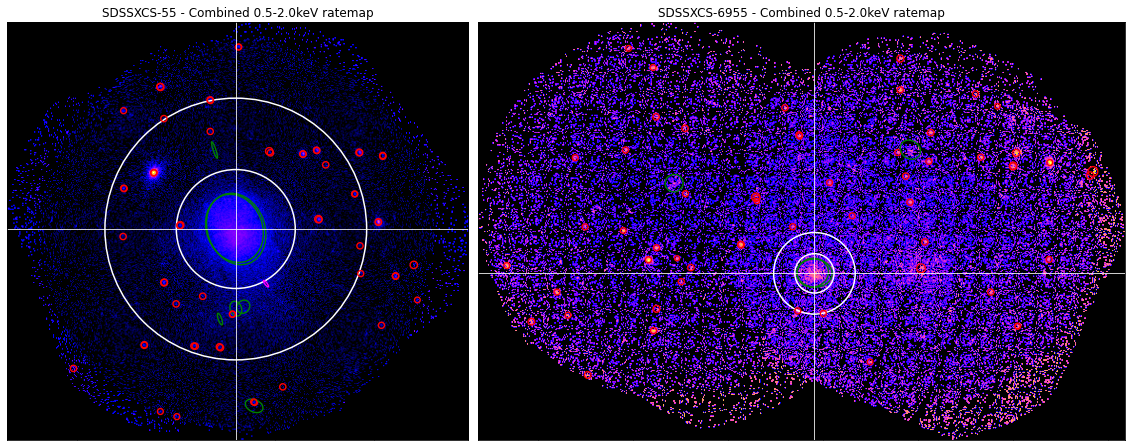

In [7]:
# Set up the figure size, this was adjusted until I thought it looked good - then set up the figure object
fig_size = (16.4, 5.8)
fig = plt.figure(figsize=fig_size)

# Grab the combined 0.5-2.0keV ratemap for SDSSXCS-55, the first example source in the sample
rt_one = examp_srcs[0].get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

# Retrieve the contaminating regions, and then add in the regions which are considered 'detections', making a 
#  dictionary where the top level keys are the ObsIDs associated with this source
src_one_all_reg = {o: r + [examp_srcs[0].matched_regions[o]] 
                   for o, r in no_cust_reg_src.get_interloper_regions().items()}
# Then add the region information to the RateMap
rt_one.regions = src_one_all_reg

# We repeat the same process as above, but for the second demonstration source, SDSSXCS-6955
rt_two = examp_srcs[1].get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
src_two_all_reg = {o: r + [examp_srcs[1].matched_regions[o]] 
                   for o, r in examp_srcs[1].get_interloper_regions().items()}
rt_two.regions = src_two_all_reg

# A bodge-factor I was going to allow for a spacing in between the two ratemaps
plt_buff = 1

# Getting a total length (in pixels) of the two ratemaps - this was in order to try and figure out good 
#  coordinates for the axes to be added to the figure. It all got a bit hand wavey though, and I just adjusted
#  things further down until I ended up with a nice looking figure.
tot_x = rt_one.shape[1] + rt_two.shape[1] + plt_buff

# Want to overlay the R500 and R2500 radii on the images, in which case we needed to convert the kpc values to
#  pixel radii valid for these ratemaps. For that we use a handy XGA function, physical_rad_to_pix. Needs radius,
#  image/ratemap, redshift, and cosmology information
src_one_r500 = physical_rad_to_pix(rt_one, examp_srcs[0].r500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, 
                                   xcs_cosmo).value
src_one_r2500 = physical_rad_to_pix(rt_one, examp_srcs[0].r2500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, 
                                    xcs_cosmo).value
# Same process as above but for SDSSXCS-6955
src_two_r500 = physical_rad_to_pix(rt_two, examp_srcs[1].r500, examp_srcs[1].ra_dec, examp_srcs[1].redshift, 
                                   xcs_cosmo).value
src_two_r2500 = physical_rad_to_pix(rt_two, examp_srcs[1].r2500, examp_srcs[1].ra_dec, examp_srcs[1].redshift, 
                                    xcs_cosmo).value

# Created an axes that should be about the right size for the SDSSXCS-55 ratemap
rt_one_ax = fig.add_axes((0, 0, rt_one.shape[1]/tot_x, 1))
# Then passed it as the first argument of get_view, which will populate it with the standard XGA photometric product
#  view figure - I specify zoom_in, which reduces the empty space around the image, view_regions so we see the source
#  regions overlaid, and pass pixel radii to plot R2500 and R500
rt_one.get_view(rt_one_ax, examp_srcs[0].ra_dec, zoom_in=True, view_regions=True, 
                radial_bins_pix=[src_one_r2500, src_one_r500])

# Another bodge factor to make the gap between the two ratemaps look good
bodge_x = 30
# Same process as above, but for SDSSXCS-6955
rt_two_ax = fig.add_axes(((rt_one.shape[1] + plt_buff - bodge_x)/tot_x, 0, rt_two.shape[1]/tot_x, 1))
rt_two.get_view(rt_two_ax, examp_srcs[1].ra_dec, zoom_in=True, view_regions=True, 
                radial_bins_pix=[src_two_r2500, src_two_r500])

# Save the resulting figure, as well as showing it in the notebook
plt.savefig('../outputs/figures/demo_clusters_RT.pdf', bbox_inches='tight')
plt.show()

## Masking demonstration for SDSSXCS-55 

Here we demonstrate the automatic mask generation capabilities of XGA, if it has been supplied with region files. This is where the slightly bodgy declaration of a modified SDSSXCS-55 source is used, where the manually adjusted region was removed. The left side of the figure shows the unmodified mask applied, and the right shows the modified mask, along with radial temperature bins for the SDSSXCS-55 annular spectra. 

The dashed lines solid white circle in the left figure is $R_{500}$, and the dashed lines are [1.05-1.5]$R_{500}$ (a background region). The outermost solid white line in the right figure is the outermost radius of the annular spectra set generated for SDSSXCS-55, which in practise will be slightly larger than $R_{500}$. The dashed lines are [1.05-1.5]$R_{\rm{outer}}$.

This is figure 2 in the paper.

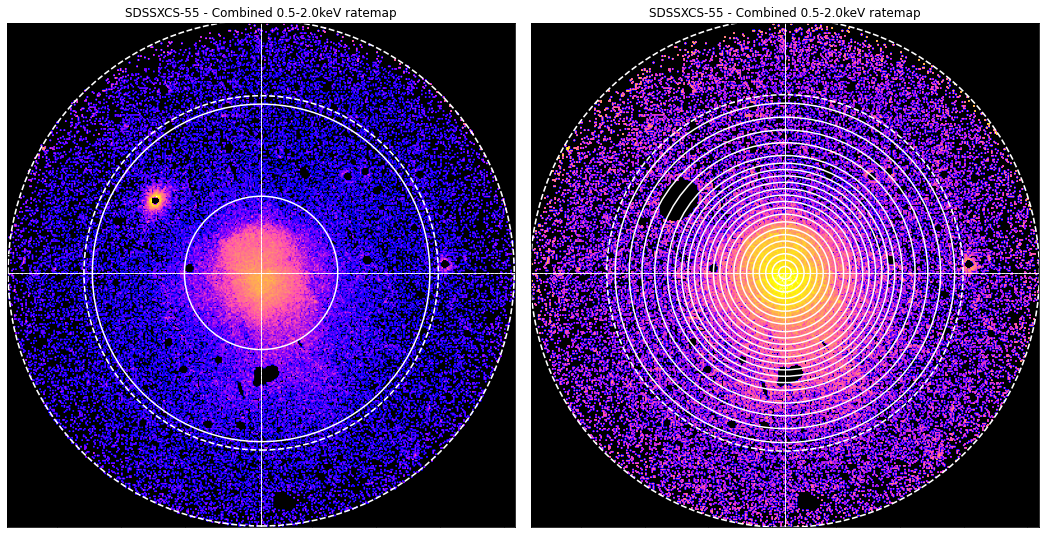

In [8]:
# Setup the matplotlib figure with a size that makes it look good
fig = plt.figure(figsize=(15, 7))

# Add an axis for the left image, which will be passed to the RateMap get_view method
no_cust_m_ax = fig.add_axes((0, 0, 0.5, 1))
# We setup a view of the ratemap with the SDSSXCS-55 UDC (a XAPA centroid in this case), the specified overlaid 
#  apertures, and a mask generated by a version of the SDSSXCS-55 XGA source that has had manual regions removed
rt_one.get_view(no_cust_m_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                no_cust_reg_src.get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, 
                radial_bins_pix=[src_one_r2500, src_one_r500], back_bin_pix=src_one_r500*np.array([1.05, 1.5]))

# We grab a projected temperature profile measured for SDSSXCS-55. We haven't gotten to profiles in this notebook 
#  yet, but I wanted this figure to multitask and have an annular region overlay for later.
temp_prof = examp_srcs[0].get_proj_temp_profiles()

# The annulus bounds property of the temperature profile contains annular bounds in kpc, so they are converted 
#  to pixels for the right ratemap
pix_anns = physical_rad_to_pix(rt_one, temp_prof.annulus_bounds, examp_srcs[0].ra_dec, 
                               examp_srcs[0].redshift, xcs_cosmo)
bck_anns = physical_rad_to_pix(rt_one, temp_prof.outer_radius, examp_srcs[0].ra_dec, 
                               examp_srcs[0].redshift, xcs_cosmo)*np.array([1.05, 1.5])

# Make an axis for the right ratemap
cust_m_ax = fig.add_axes((0.485, 0, 0.5, 1))
# Set up the right hand view, with a mask made WITH manual regions in there, zoomed in, no source regions 
#  overlaid, and with annular boundaries overlaid
rt_one.get_view(cust_m_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                 examp_srcs[0].get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, view_regions=False,
                 radial_bins_pix=pix_anns.value, back_bin_pix=bck_anns.value)

# Save and show the figure
plt.savefig("../outputs/figures/demo_cluster_mask.pdf", bbox_inches='tight')
plt.show()

## Projected $T_{\rm{X}}$ profiles for the demonstration clusters

This section of the notebook retrieves projected temperature profiles that have been measured for our two demonstration clusters through the generation and fitting of annular spectra. We reiterate that the generation and fitting process is not run in this notebook, rather we are retrieving profiles that have been read back in from disk when the XGA sample was declared.

Both clusters produce a profile, though SDSSXCS-55 is able to have significantly more annular bins than SDSSXCS-6955. Two versions of the plot are shown in this notebook, but only the first is saved, and is used in the paper as Figure 3. We overlay the 'global' $R_{500}$ temperature on the y-axis of the saved figure for context:

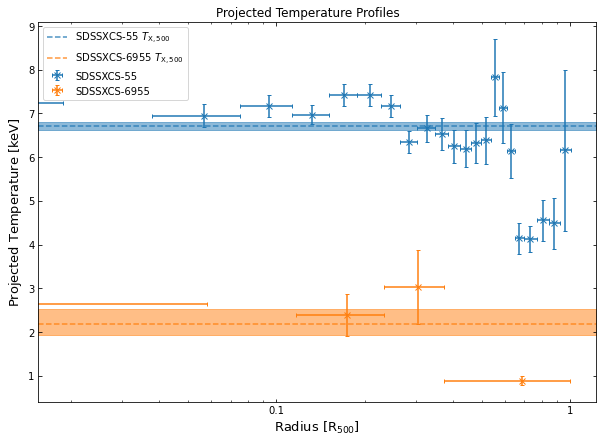

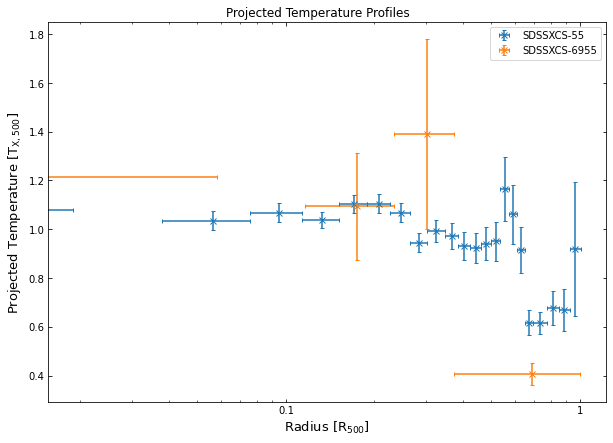

In [12]:
# This sets up a custom Astropy unit that I use to normalise the temperature profiles values in the second version
#  of this figure, the one that ISN'T saved and used in the paper - it just ensures that the y-axis units are correct
t500_unit = def_unit('t500', format={'latex': r"\mathrm{T_{X,500}}"})

# Retrieve the projected temperature profile for SDSSXCS-55 (if multiple temperature profiles existed I would have
#  to pass more information to specify exactly which one to retrieve)
tp_one = examp_srcs[0].get_proj_temp_profiles()
# We set a value to (optionally) normalise the radius values by. This is set to R500, in units of kpc/R500 so 
#  that the x-axis units are correct in the plot
tp_one.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
# Same deal with y-axis normalisation, though is only used in the second, unsaved, plot that isn't used in the paper
t_one = examp_srcs[0].get_temperature('r500')
tp_one.y_norm = t_one[0] / Quantity(1, t500_unit)

# Exactly the same deal but for the SDSSXCS-6955 projected temperature profile
tp_two = examp_srcs[1].get_proj_temp_profiles()
tp_two.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)
t_two = examp_srcs[1].get_temperature('r500')
tp_two.y_norm = t_two[0] / Quantity(1, t500_unit)

# This tells the view method how to format the x-axis labels (makes sure they are 0.1, 1 rather than 1e-1, 1e+0)
forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}

# XGA profiles can be added together and viewed to produce joint plots. This happens here, and we overlay the 
#  global temperature values (with uncertainty), with a normalised x-axis, and save it.
(tp_one + tp_two).view(x_norm=True, y_norm=False, draw_vals={r'SDSSXCS-55 $T_{\rm{X,500}}$': [t_one, 'tab:blue'], 
                                                             r'SDSSXCS-6955 $T_{\rm{X,500}}$': [t_two, 'tab:orange']},
                       yscale='linear', save_path="../outputs/figures/demo_clusters_projtemp.pdf", 
                       axis_formatters=forms)

# This creates another version of the figure that is not saved or used, but includes y-axis normalisation also
(tp_one + tp_two).view(x_norm=True, y_norm=True, yscale='linear', axis_formatters=forms)

## Showing the effect of PSF correction for SDSSXCS-55 ratemap

This very simply shows a before and after PSF correction of the combined ratemap for SDSSXCS-55. The ratemap itself is 0.5-2.0keV, and no contaminating source masking is applied. Two versions of this plot are in this notebook, but only the first is saved and used in the paper as figure 4.

The chief difference is that in the first, we apply a circular aperture mask with radius $R_{500}$, and overlay an $R_{500}$ radius as a white circle in an attempt to make clear the comparison to previous ratemaps of this cluster. In the second we manually zoom in on a square 2x2$R_{500}$ region:

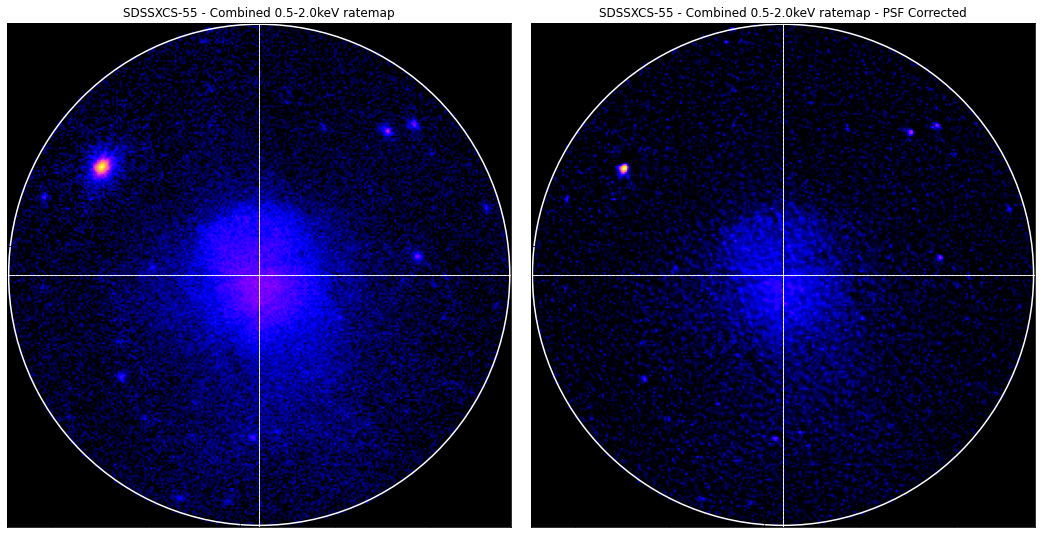

In [15]:
# Retrieve the PSF corrected combined ratemap that we want for this figure
rt_one_psfc = examp_srcs[0].get_combined_ratemaps(psf_corr=True, psf_bins=10, lo_en=Quantity(0.5, 'keV'), 
                                                  hi_en=Quantity(2.0, 'keV'))

# Set up the matplotlib figure that will contain the two ratemaps, before on the left, after on the right
fig = plt.figure(figsize=(15, 7))
# Create an ax for before, and pass it through the get_view method
normal_ax = fig.add_axes((0, 0, 0.5, 1))
# Make a view of the non-corrected ratemap with a crosshair, white outline for R500, and mask for R500
rt_one.get_view(normal_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                examp_srcs[0].get_custom_mask(examp_srcs[0].r500, remove_interlopers=False), zoom_in=True, 
                radial_bins_pix=[src_one_r500])

# Same deal as above, but for the corrected ratemap
psf_corr_ax = fig.add_axes((0.485, 0, 0.5, 1))
rt_one_psfc.get_view(psf_corr_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), 
                     examp_srcs[0].get_custom_mask(examp_srcs[0].r500, remove_interlopers=False), zoom_in=True, 
                     radial_bins_pix=[src_one_r500])
# Save and show the figure
plt.savefig("../outputs/figures/demo_cluster_psfcorr.pdf", bbox_inches='tight')
plt.show()

This shows the alternate figure, not used in the paper or saved, but with a manual zoom-in to a square region:

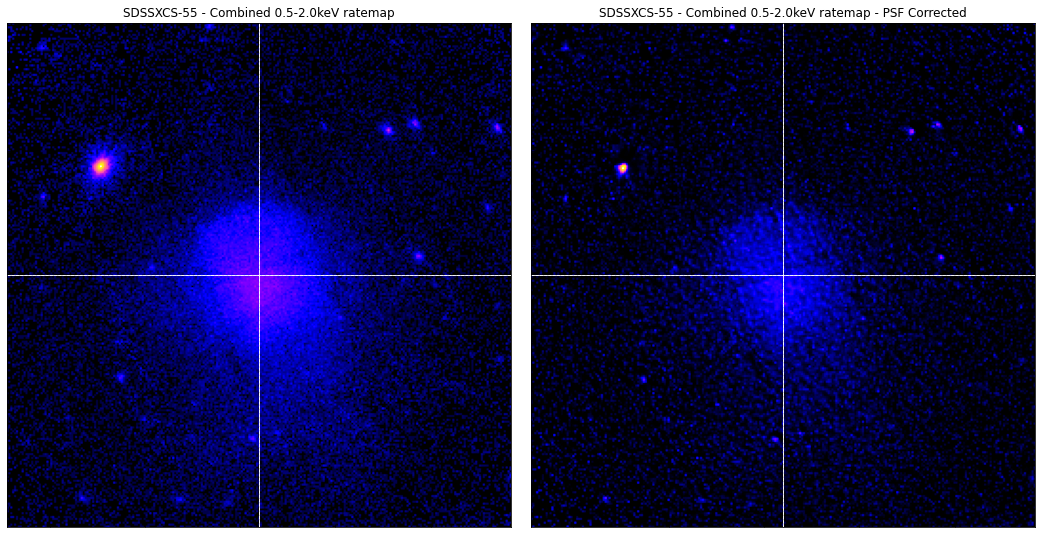

In [13]:
# Retrieve the PSF corrected combined ratemap that we want for this figure
rt_one_psfc = examp_srcs[0].get_combined_ratemaps(psf_corr=True, psf_bins=10, lo_en=Quantity(0.5, 'keV'), 
                                                  hi_en=Quantity(2.0, 'keV'))

# Calculate the R500 in units of pixels for these two ratemaps
hh = physical_rad_to_pix(rt_one_psfc, examp_srcs[0].r500, examp_srcs[0].ra_dec, examp_srcs[0].redshift, xcs_cosmo)
# Convert the central coordinate we are using (the UDC) into pixels for these ratemaps
pix_coord = rt_one_psfc.coord_conv(examp_srcs[0].ra_dec, 'pix')
# Figure out the lower and upper limits on x and y pixels that correspond to a square 2x2R500 region
x_lims = Quantity([pix_coord[0]-hh, pix_coord[0]+hh]).value
y_lims = Quantity([pix_coord[1]-hh, pix_coord[1]+hh]).value

# Make the figure in the same way as the first, but applying a manual set of x and y lims rather than a circular mask
fig = plt.figure(figsize=(15, 7))
normal_ax = fig.add_axes((0, 0, 0.5, 1))
rt_one.get_view(normal_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), zoom_in=True, 
                manual_zoom_xlims=x_lims, manual_zoom_ylims=y_lims)

psf_corr_ax = fig.add_axes((0.485, 0, 0.5, 1))
rt_one_psfc.get_view(psf_corr_ax, Quantity([examp_srcs[0].peak, examp_srcs[0].ra_dec]), zoom_in=True,
                 manual_zoom_xlims=x_lims, manual_zoom_ylims=y_lims)
# Show the figure
plt.show()

## Surface brightness profiles for the demonstration clusters

Here we make another figure that shows profiles for the two clusters we're demonstrating with - this time the surface brightness profiles. These have been generated from our PSF corrected images, and are used for the measurement of density profiles. The models fit to these brightness profiles are also shown, along with residuals. This is used as Figure 5 in the paper: 

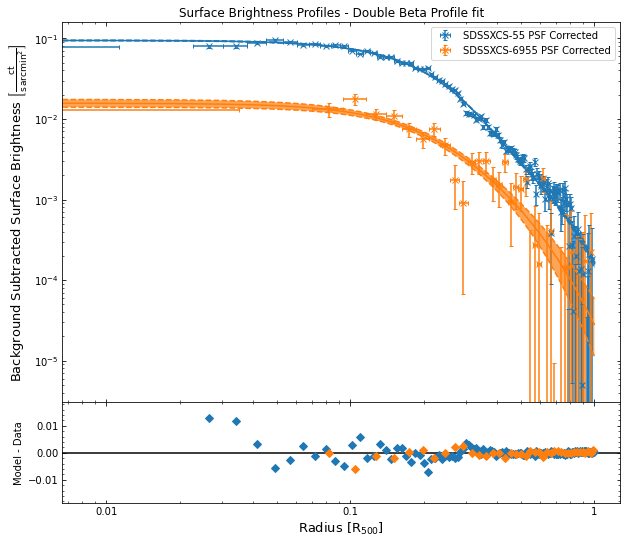

In [16]:
# We retrieve the surface brightness profile for SDSSXCS-55
src_one_bp = examp_srcs[0].get_profiles('combined_brightness')[0]
# Then again add R500 information (in units of kpc/R500 so that the x-axis units of the plot are correct) to 
#  normalise x-axis values by
src_one_bp.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
# Same process but for SDSSXCS-6955
src_two_bp = examp_srcs[1].get_profiles('combined_brightness')[0]
src_two_bp.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)

# Again we set up a formatter so that the x-axis tick labels are 0.1, 1 rather than 10^-1, 10^0
forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
# This shows and saves the combined plot
(src_one_bp + src_two_bp).view(x_norm=True, model='double_beta', show_residual_ax=True,
                               save_path='../outputs/figures/demo_clusters_sb.pdf', axis_formatters=forms)

In [ ]:
# src_one_dp.generation_profile.get_model_fit('beta', 'mcmc').par_dist_view()

In [ ]:
# sb_mod = src_one_dp.generation_profile.get_model_fit('double_beta', 'mcmc')
# sb_mod.par_dist_view()

In [ ]:
src_one_dp = examp_srcs[0].get_density_profiles()[0]
src_one_dp.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
# src_one_dp.view(x_norm=True, just_models=True, show_residual_ax=False)
# src_one_dp.save_view('../outputs/figures/demo_clusters_dens.pdf', x_norm=True, just_models=True, 
#                      show_residual_ax=False)

src_two_dp = examp_srcs[1].get_density_profiles()
src_two_dp.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
(src_one_dp + src_two_dp).view(x_norm=True, model='simple_vikhlinin_dens', just_model=True, 
                               save_path='../outputs/figures/demo_clusters_dens.pdf', 
                               axis_formatters=forms, show_residual_ax=False)

In [ ]:
# emosaic(examp_srcs, 'image', Quantity(2.0, 'keV'), Quantity(8.0, 'keV'))
# emosaic(examp_srcs, 'expmap', Quantity(2.0, 'keV'), Quantity(8.0, 'keV'))
examp_srcs[0].get_combined_ratemaps(Quantity(2.0, 'keV'), Quantity(8.0, 'keV')).view()

In [ ]:
# src_one_dp.gas_mass('simple_vikhlinin_dens', examp_srcs[0].r500)

In [ ]:
# dps = inv_abel_fitted_model(examp_srcs, 'double_beta', outer_radius=examp_srcs.r500*1.01)

In [ ]:
# dps[0].src_name = 'SDSSXCS-55'

In [ ]:
# (dps[0]+src_one_dp).view()

In [ ]:
# dps[0].fit('simple_vikhlinin_dens')
# dps[0].gas_mass('simple_vikhlinin_dens', examp_srcs[0].r500)

6.62246394e+13, 1.37141002e+11, 1.43774170e+11] solMass

[7.91776613e+13, 1.75464875e+11, 1.85142951e+11] solMass

In [ ]:
stop

In [ ]:
tp_one.outer_radius / examp_srcs[0].r500

In [ ]:
pix_anns = physical_rad_to_pix(rt_one_no_cust, tp_one.annulus_bounds, examp_srcs[0].ra_dec, 
                               examp_srcs[0].redshift, xcs_cosmo)
rt_one.view(examp_srcs[0].ra_dec, examp_srcs[0].get_custom_mask(examp_srcs[0].r500*1.5), zoom_in=True, 
            radial_bins_pix=pix_anns.value, back_bin_pix=src_one_r500*np.array([1.05, 1.5]), view_regions=False)

In [ ]:
examp_srcs[0].get_apec_norm_profiles().view(xscale='linear')
examp_srcs[0].get_apec_norm_profiles().emission_measure_profile(examp_srcs[0].redshift, 
                                                                examp_srcs[0].cosmo).view(xscale='linear')

In [ ]:
tp3d_one = examp_srcs[0].get_3d_temp_profiles()
tp3d_one.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
tp3d_one.view(xscale='linear')

tp3d_two = examp_srcs[1].get_3d_temp_profiles()
tp3d_two.x_norm = examp_srcs[1].r500 / Quantity(1, r500_unit)
tp3d_two.view(xscale='linear')

In [ ]:
(tp3d_one + tp3d_two).view(model='simple_vikhlinin_temp', x_norm=True, 
                           save_path='../outputs/figures/demo_clusters_3dtemp.pdf')

In [ ]:
num_real = 10000

apec_norm_prof = examp_srcs[0].get_apec_norm_profiles()
proj_temp = examp_srcs[0].get_proj_temp_profiles()

# Also make an Emission Measure profile, used for weighting the contributions from different
#  shells to annuli
em_prof = apec_norm_prof.emission_measure_profile(examp_srcs[0].redshift, examp_srcs[0].cosmo, 'angr',
                                                  num_real, 1)
# src.update_products(em_prof)

cur_rads = proj_temp.annulus_bounds
# Need to make sure the annular boundaries are a) in a proper distance unit rather than degrees, and b)
#  in units of centimeters
cur_rads = examp_srcs[0].convert_radius(cur_rads, 'cm')

# Use a handy function I wrote to calculate the volume intersections of spherical shells and
#  projected annuli
vol_intersects = shell_ann_vol_intersect(cur_rads, cur_rads)

# Then it's an inverse matrix problem to recover the 3D temperatures
temp_3d = (np.linalg.inv(vol_intersects.T) @ (proj_temp.values * em_prof.values)) / (np.linalg.inv(
    vol_intersects.T) @ em_prof.values)

# I generate random realisations of the projected temperature profile and the emission measure profile
#  to help me with error propagation
proj_temp_reals = proj_temp.generate_data_realisations(num_real, truncate_zero=True)
em_reals = em_prof.generate_data_realisations(num_real, truncate_zero=True)

# Set up an N x R array for the random realisations of the 3D temperature, where N is22 the number
#  of realisations and R is the number of radius data points
temp_3d_reals = Quantity(np.zeros(proj_temp_reals.shape), proj_temp_reals.unit)
for i in range(0, num_real):
    # Calculate and store the 3D temperature profile realisations
    interim = (np.linalg.inv(vol_intersects.T) @ (proj_temp_reals[i, :] * em_reals[i, :])) / (np.linalg.inv(
        vol_intersects.T) @ em_reals[i, :])
    temp_3d_reals[i, :] = interim

# Calculate a standard deviation for each bin to use as the uncertainty
temp_3d_sigma = np.std(temp_3d_reals, axis=0) * 1
print(temp_3d_sigma)
meddo = np.percentile(temp_3d_reals, 50, axis=0)
# temp_3d_sigma = 
upper = np.percentile(temp_3d_reals, 84.1, axis=0)
lower = np.percentile(temp_3d_reals, 15.9, axis=0)

temp_3d_sigma = Quantity(np.average([meddo-lower, upper-meddo], axis=0), 'keV')
print(temp_3d_sigma.max())

# And finally actually set up a 3D temperature profile
temp_3d_prof = GasTemperature3D(proj_temp.radii, temp_3d, proj_temp.centre, proj_temp.src_name, '', '',
                                proj_temp.radii_err, temp_3d_sigma, proj_temp.set_ident,
                                proj_temp.associated_set_storage_key, proj_temp.deg_radii)

In [ ]:
em_prof.values

[8.8788389×1065, 2.4657492×1066, 3.5051941×1066, 4.218654×1066, 4.3558862×1066, 4.0679324×1066, 3.5533423×1066, 3.0876882×1066, 2.7106749×1066, 1.8031576×1066, 1.6392937×1066, 1.3901464×1066, 1.2579137×1066, 1.1224021×1066, 1.0704064×1066, 9.1677035×1065, 9.6988353×1065, 1.2314494×1066, 1.5940846×1066, 1.0941704×1066, 1.195449×1066, 7.6625552×1065]cm2cm5

In [ ]:
temp_3d

[9.3511571, 6.1517938, 7.8291867, 6.1316733, 7.5474896, 7.7128579, 8.6267035, 5.9868031, 6.8546284, 7.1116085, 6.3947824, 5.704497, 6.8000125, 2.5968047, 10.109687, 11.192072, 15.602915, 4.2167505, 3.6250735, 5.3480357, 3.0384646, 6.15485]keV

In [ ]:
tp_one.view()
temp_3d_prof.fit('simple_vikhlinin_temp')
temp_3d_prof.view()

In [ ]:
temp_3d_prof.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
(temp_3d_prof+tp3d_two).view(model='simple_vikhlinin_temp', x_norm=True, yscale='log',
                           save_path='../outputs/figures/demo_clusters_3dtemp.pdf')


In [ ]:
src_one_dp.view()

In [ ]:
temp_3d_prof.view()

In [ ]:
temp_model.derivative(Quantity(100, 'kpc'))*temp_model.

In [ ]:
temp_3d_reals.min()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(temp_3d_reals[:, 0].value, bins='auto')
plt.show()

In [ ]:
em_prof.view()

In [ ]:
from scipy.stats import truncnorm
loc = tp_one.values.value
scale = tp_one.values_err.value

lims = ((0 - loc) / scale, (np.inf - loc) / scale)
print(lims)

# Here I copy the values and value uncertainties N times, where N is the number of realisations
#  the user wants
ext_values = np.repeat(tp_one.values[..., None], 10000, axis=1).T
ext_value_errs = np.repeat(tp_one.values_err[..., None], 10000, axis=1).T

# Then I just generate N realisations of the profiles using a normal distribution, though this does assume
#  that the errors are one sigma which isn't necessarily true
# realisations = np.random.normal(ext_values, ext_value_errs)
testo = truncnorm(lims[0], lims[1], loc=loc, scale=scale).rvs([10000, 22])
print(testo.shape)
plt.hist(testo[:, -2])

# realisations = Quantity(realisations, self.values_unit)

# dir(truncnorm(0, np.inf, loc=1, scale=0.4))

In [ ]:
(temp_3d_prof+tp3d_one).view(xscale='linear')

In [ ]:
(temp_3d_reals[:, -7] > 0).sum()

In [ ]:
plt.hist(temp_3d_reals[:, -7].value)

In [ ]:
temp_3d_reals[:, -7].value.max()

In [ ]:
temp_3d_reals[:, -7].value.std()

In [ ]:
np.percentile(temp_3d_reals[:, -7].value, 84.1) - np.percentile(temp_3d_reals[:, -7].value, 50)

In [ ]:
np.percentile(temp_3d_reals[:, -7].value, 50) - np.percentile(temp_3d_reals[:, -7].value, 15.9)

In [ ]:
len(examp_srcs[0].get_annular_spectra(set_id=tp3d_one.set_ident).all_spectra)

In [ ]:
len(examp_srcs[1].get_annular_spectra(set_id=tp3d_two.set_ident).all_spectra)

In [ ]:
examp_srcs[0].info()

In [ ]:
examp_srcs[0].get_hydrostatic_mass_profiles()

In [ ]:
import json
with open('../data_notes/obs_info.json', 'r') as reado:
    obso = json.load(reado)
    
print(len(obso))

In [ ]:
len(set(list(obso.keys())))

In [ ]:
raddoo = temp_3d_prof.radii
raddoo[0] = Quantity(20, 'kpc')

hym = HydrostaticMass(temp_3d_prof, 'simple_vikhlinin_temp', src_one_dp, 'simple_vikhlinin_dens', 
                      raddoo, temp_3d_prof.radii_err, temp_3d_prof.deg_radii)

In [ ]:
examp_srcs[0].r500

In [ ]:
example_clusters[['name', 'r500','r500-', 'r500+']]

In [ ]:
hym.mass(examp_srcs[0].r500)

In [ ]:
m_err = hym.mass(examp_srcs[0].r500, radius_err=Quantity(20, 'kpc'))

In [ ]:
m = hym.mass(examp_srcs[0].r500)

In [ ]:
plt.figure()
plt.hist(m[1].value, alpha=0.6)
plt.hist(m_err[1].value, alpha=0.6)
plt.show()


[5.16036032e+14 5.78980944e+13 5.79106213e+13] solMass

In [ ]:
hym.x_norm = examp_srcs[0].r500 / Quantity(1, r500_unit)
hym.view(x_norm=True)
hym.save_view('../outputs/figures/demo_clusters_hym.pdf', x_norm=True)

In [ ]:
import json

with open('../data_notes/obs_info.json', 'r') as whicho:
    used_obs = json.load(whicho)

In [ ]:
len([o for o in used_obs if len([ns for ns in used_obs[o] if 'SDSSXCS-' in ns])])

In [ ]:
len([o for o in used_obs if len([ns for ns in used_obs[o] if 'XLSSC' in ns])])